In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

In [3]:
day188 = import_data(day=188, starttime='2019-07-07T08:40:00.0Z', endtime='2019-07-07T10:15:00.0Z')

In [4]:
day197 = import_data(day=197, starttime='2019-07-16T21:45:00.0Z', endtime='2019-07-17T00:00:00.337999Z')

In [5]:
day211 = import_data(day=211, starttime='2019-07-30T22:30:05.142999Z', endtime='2019-07-30T23:07:04.430999Z')

In [6]:
day141[0].stats

         network: 7F
         station: A00
        location: 01
         channel: GDH
       starttime: 2019-05-21T07:00:00.000000Z
         endtime: 2019-05-21T09:00:00.000000Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 7200001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 14851, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 60829696})
      processing: ['ObsPy 1.3.0: trim(endtime=UTCDateTime(2019, 5, 21, 9, 0)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 5, 21, 7, 0))']

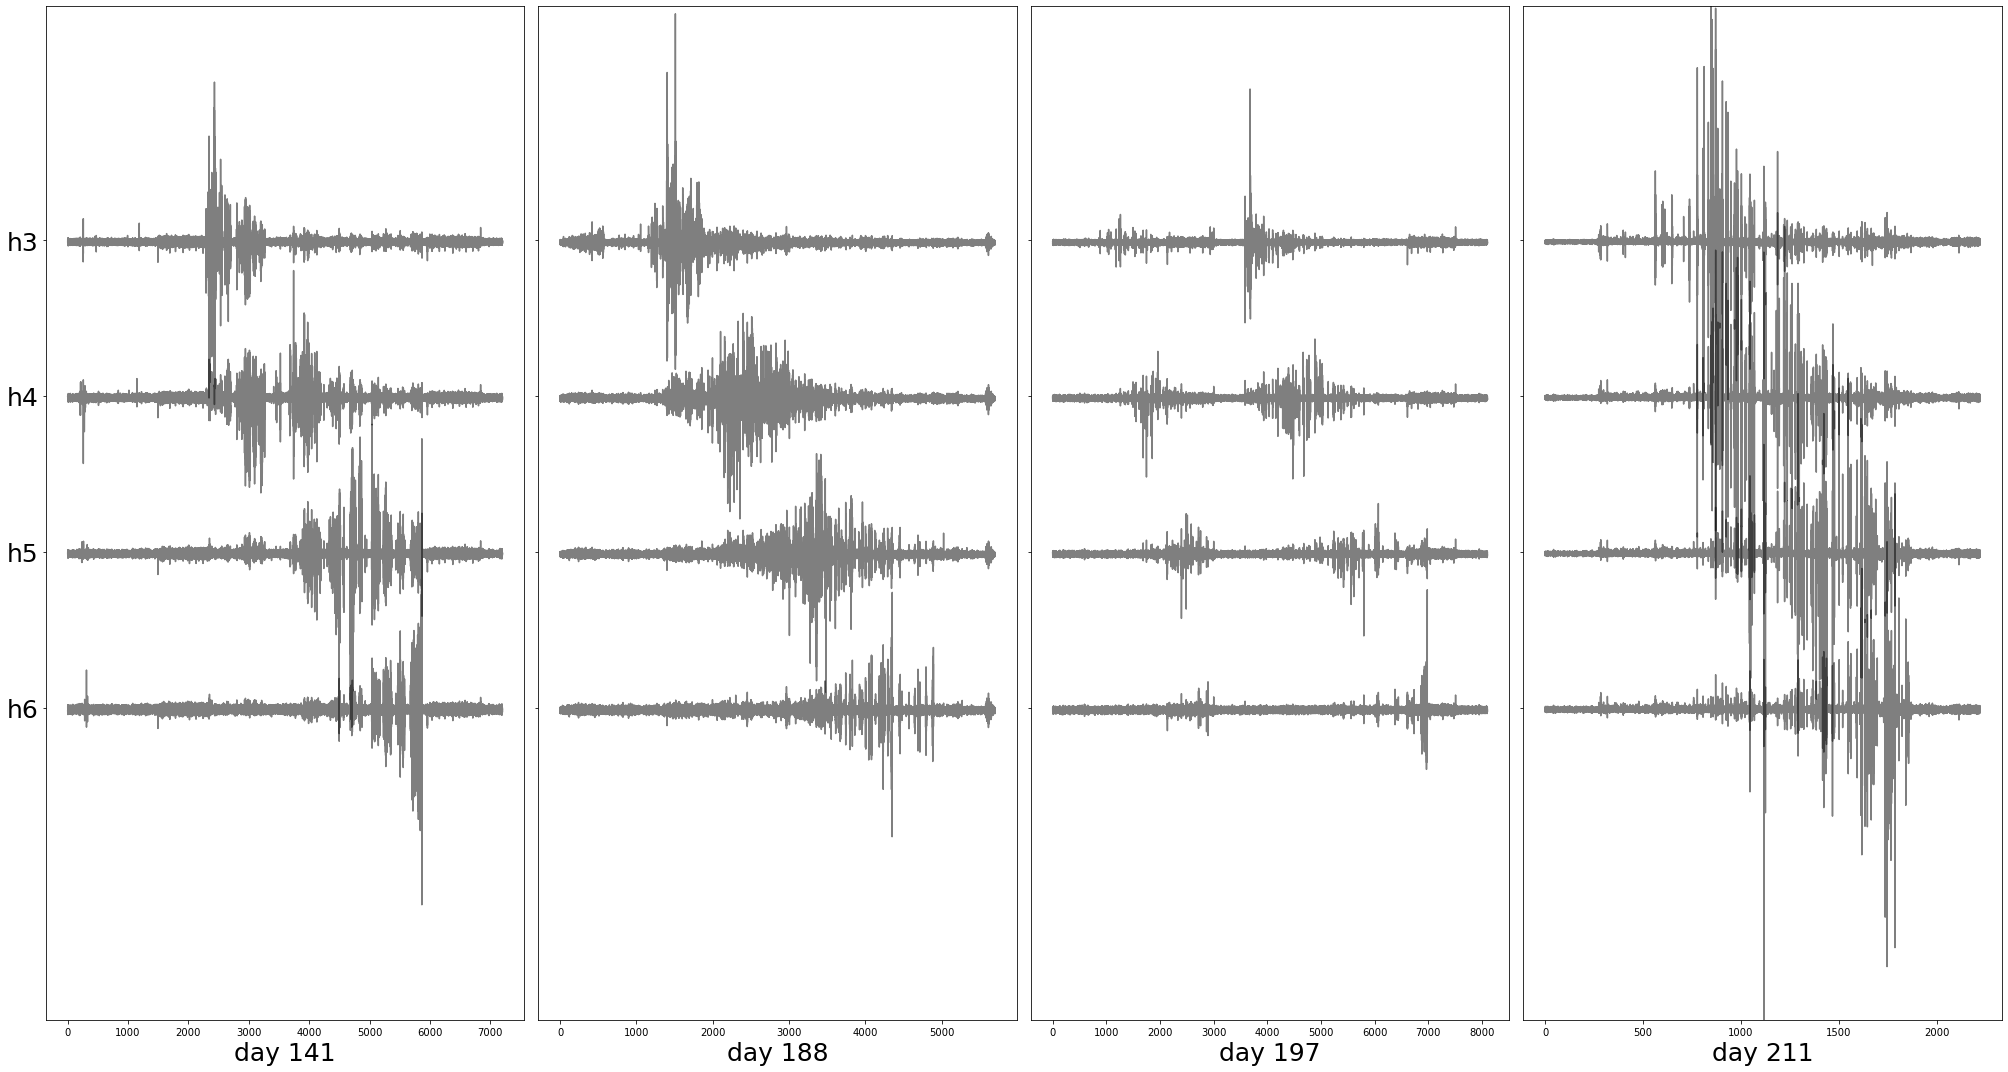

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(7*4, 15), sharey=True)

def plot_waveform(ax, stream, day):
    times = [tr.times() for tr in stream][2:]
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 10, color='black', alpha=0.5)
        n+=1
        
    ax.set_xlabel('day ' + str(day), fontsize=25)

plot_waveform(ax=ax[0], stream=day141, day=141)
plot_waveform(ax=ax[1], stream=day188, day=188)
plot_waveform(ax=ax[2], stream=day197, day=197)
plot_waveform(ax=ax[3], stream=day211, day=211)

ax[0].set_ylim(-50, 15)
ax[0].set_yticks([0, -10, -20, -30])
ax[0].set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=25)

plt.tight_layout()

fig.savefig('figures/raw_waveforms.pdf', bbox_inches='tight')

In [8]:
import matplotlib.dates as dates

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def plot_depths(df, cmap, day):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df.arrival_datetime, df.depth, marker='.', linewidth=0, c=df.first_hydrophone, cmap=cmap)
    ax.set_ylabel('day '+str(day), fontsize=25)
    ax.set_ylim(400, 50)
    # ax.text(s='N_events={}'.format(df.shape[0]), x=df.arrival_time[50], y=375, fontsize=25)
    return fig, ax

def plot_radius(df, cmap, day):
    x = df.first_arrival.values
    y = np.abs(df.radius.values)
    c = df.depth.values
    
    fig, ax = plt.subplots(figsize=(15, 5))
    cbar = ax.scatter(x, y, marker='.', c=c, vmin=150, vmax=400, cmap=cmap)
    ax.set_xticks([])
    ax.set_ylim(-10, 60)
    fig.colorbar(cbar, label='depth (m)')
    ax.set_xlabel('time ---->', fontsize=15)
    ax.set_ylabel('radius (m)', fontsize=15)
    return fig, ax

In [12]:
df141 = import_catalog(file='141precision.csv')
df188 = import_catalog(file='188precision.csv')
df197 = import_catalog(file='197precision.csv')
df211 = import_catalog(file='211precision.csv')

number of raw events: 325
number of events after max amplitude removal: 260
fraction removed: 0.19999999999999996


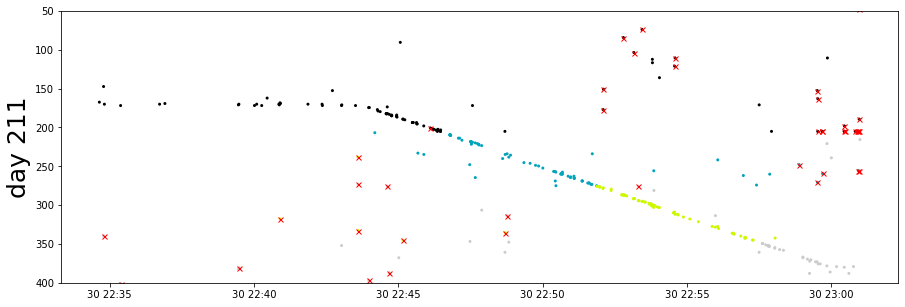

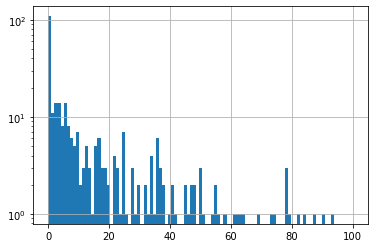

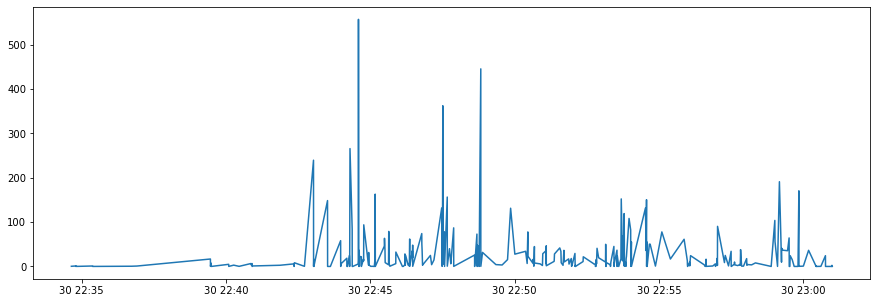

In [68]:
# The detection algorithm doesn't work for events with maximum amplitude <0.1, therefore it is likely these events are false positives and need to be removed. This can be demonstrated below.

data = df211.copy()
data_filter = data[data.max_amp > 0.1].copy()
filtered_events = data.drop(data_filter.index)

fig, ax = plot_depths(data, cmap='nipy_spectral', day=211)
ax.plot(filtered_events.arrival_datetime, filtered_events.depth, marker='x', color='red', markersize=5, linewidth=0)
print('number of raw events:', data.shape[0])
print('number of events after max amplitude removal:', data_filter.shape[0])
print('fraction removed: {}'.format(1-data_filter.shape[0]/data.shape[0]))
# ax.text(s='fraction of events left: {}%'.format(round(data.shape[0]/data_filter.shape[0],2))
       # ,x=data.arrival_datetime[50], y=350)

fig, ax = plt.subplots()
data.max_amp.hist(ax=ax, bins=np.linspace(0, 100, 100), log=True)
data.max_amp.sort_values().tail()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(data.arrival_datetime, data.max_amp)

In [ ]:
# removing the events with maximum amplitude <0.1 since they are false positives

df141 = df141[df141.max_amp > 0.1].copy()
df188 = df188[df188.max_amp > 0.1].copy()
df197 = df197[df197.max_amp > 0.1].copy()
df211 = df211[df211.max_amp > 0.1].copy()

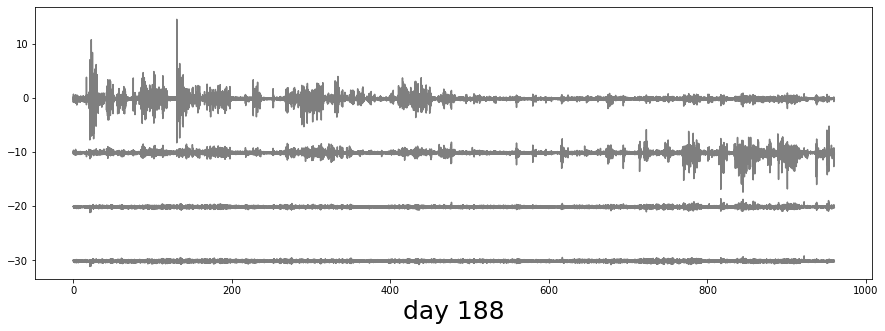

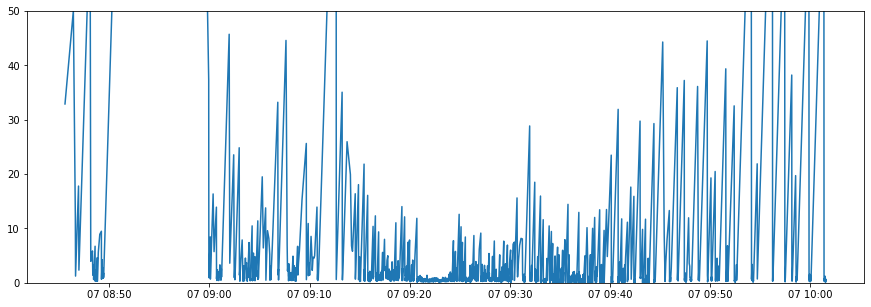

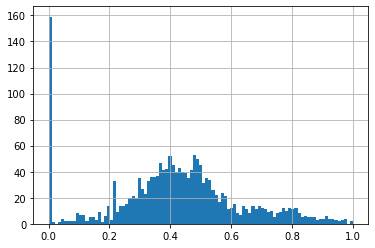

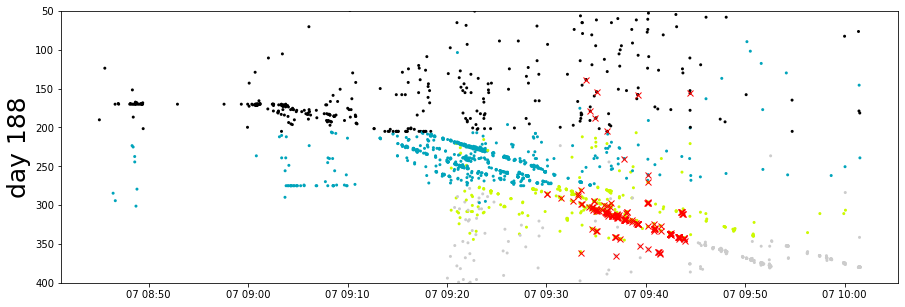

In [64]:
# there is data to remove per the below evidence

# there are no events at depths of approx 350m before 09:20:00 on teh waveform data
# %matplotlib widget
# fig, ax = plt.subplots(figsize=(15, 5))
# starttime = obspy.UTCDateTime('2019-07-07T09:03:00')
# endtime = obspy.UTCDateTime('2019-07-07T09:19:00')
# plot_waveform(ax=ax, stream=day188.slice(starttime, endtime), day=188)

# x = df188.arrival_datetime
# y = df188.arrival_datetime.diff().apply(lambda t: t.total_seconds())
# fig, ax = plt.subplots(figsize=(15, 5))
# ax.plot(x, y)
# ax.set_ylim(0, 50)

# fig, ax = plt.subplots()
# y.hist(ax=ax, bins=np.linspace(0, 1, 100))

# fig, ax = plot_depths(df188, cmap='nipy_spectral', day=188)

# zeros = df188.loc[y[y<0.001].index]
# ax.plot(zeros.arrival_datetime, zeros.depth, marker='x', color='red', linewidth=0)

In [11]:
# remove spurious deep detections in day 188
# df188.drop(df188[df188.first_hydrophone.isin([4, 5]) & df188.arrival_datetime.between('2019-07-07 08:00:00', '2019-07-07 09:20:00')].index, inplace=True)

<AxesSubplot:>

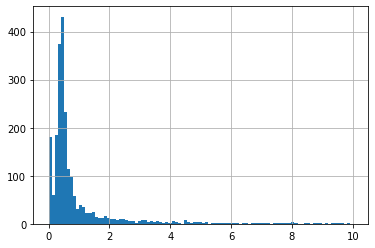

In [69]:
# event rates

# df188.arrival_datetime.diff().apply(lambda t: t.total_seconds()).hist(bins=np.linspace(0, 10, 100))

In [12]:
from event_pipeline import Event
event_id = 1251
paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=141)
waveforms = load.import_corrected_data_for_single_day(paths=paths)
e = Event(id=event_id, starttime=df141.arrival_time.iloc[event_id], init_first_hphone=df141.first_hydrophone, waveforms=waveforms)
# e.aics
print('loaded event {} successfully.'.format(event_id))

loaded event 1251 successfully.


0:00:00.179000
big arrival start time 0:00:00.253000
evenet depth 275.0 -35.0
arrival hydrophone 4
origin time: -0.08600000000000001


[18037.346064432873,
 18037.346064432873,
 18037.3460594213,
 18037.346058923613,
 18037.346061597225,
 18037.346058923613]

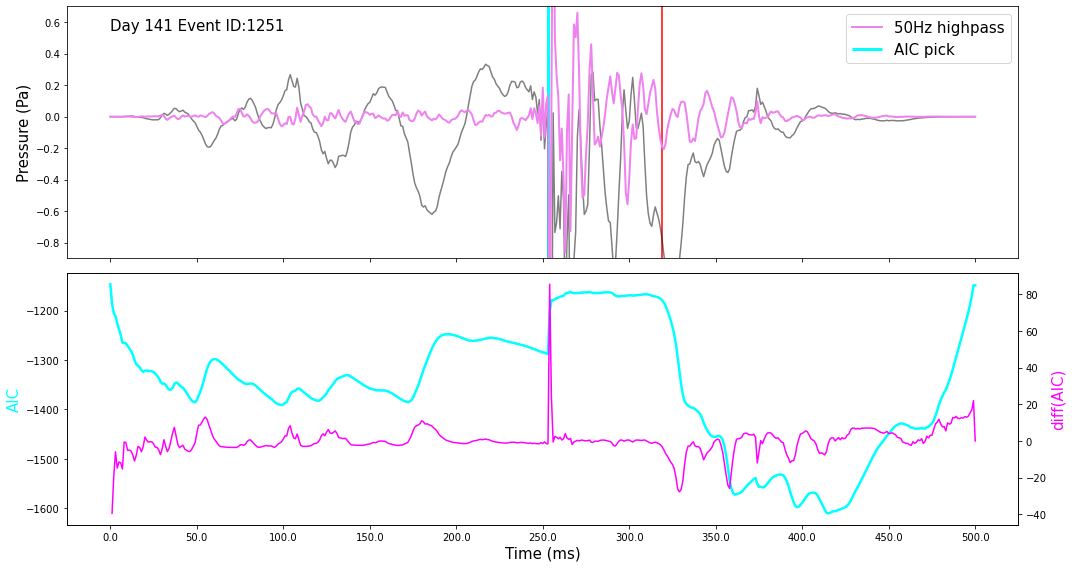

In [13]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

t_labels = e.stream[4].times() * 1e3 # milliseconds
times = e.stream[4].times('matplotlib')

ax.plot(times, e.stream[4].data, color='black', alpha=0.5)

st = e.stream.copy()
st.filter(type='highpass', freq=50)
ax.plot(times, st[4].data, color='violet', label='50Hz highpass', linewidth=2)

ax.vlines(x=e.aic_t[4], ymin=-0.9, ymax=0.7, color='cyan', linewidth=3, label='AIC pick')
ax.set_ylim(-0.9, 0.7)
ax.legend(fontsize=15)
ax.set_ylabel('Pressure (Pa)', fontsize=15)
ax.text(s='Day 141 Event ID:{}'.format(event_id), fontsize=15, x=times[0], y=0.55)

ax2.plot(times, e.aics[4], color='cyan', linewidth=2.5)

ax2.set_xticks(times[::50])
ax2.set_xticklabels(t_labels[::50])
ax2.set_xlabel('Time (ms)', fontsize=15)
ax2.set_ylabel('AIC', fontsize=15, color='cyan')

ax3 = ax2.twinx()
ax3.plot(times[1:], np.diff(e.aics[4]), color='magenta')
ax3.set_ylabel('diff(AIC)', fontsize=15, color='magenta')
# ax2.fill_between([times.min(), times[100]], y1=-2800, y2=-2100, color='black', alpha=0.15, zorder=20)

fig.tight_layout()
# np.isclose(e.aic_t[4], e.stream[4].times('matplotlib'))
# e.stream.plot()

# fig.savefig('figures/example_detections.pdf', bbox_inches='tight')
pt = dates.date2num(e.parrival)
print(dates.num2date(e.aic_t[0]) - e.parrival)
ax.vlines(x=pt, ymin=-0.9, ymax=0.7, color='red')
print('big arrival start time', dates.num2date(e.aic_t[4]) - dates.num2date(e.stream[0].times('matplotlib')[0]))
print('evenet depth', e.depth, 240-e.depth)
print('arrival hydrophone', e.first_hydrophone_id+1)
print('origin time:', (dates.num2date(e.aic_t[4]) - e.parrival).total_seconds() - 35/1750)
ot = (dates.num2date(e.aic_t[4]) - e.parrival).total_seconds() - 35/1750
# ax.vlines(x=ot, ymin=-0.9, ymax=0.7, color='limegreen')
# dates.num2date(e.stream[0].times('matplotlib')[0])
35./0.080
e.aic_t

#########################
# step 1: estimate depth
# step 2: assume r=0 get origin time
# step 3: take pick for initial phase, calculate propagation velocity

# reoccurence interval between swarms
# cumulative event/time plot
# are there depth patches where there are no events across each swarms?
# what about the downward migrating swarm in BA1B?
# stop assuming geology/rheology is the same between B and A

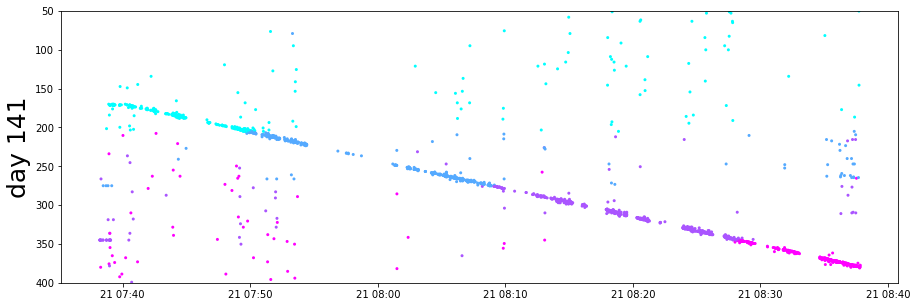

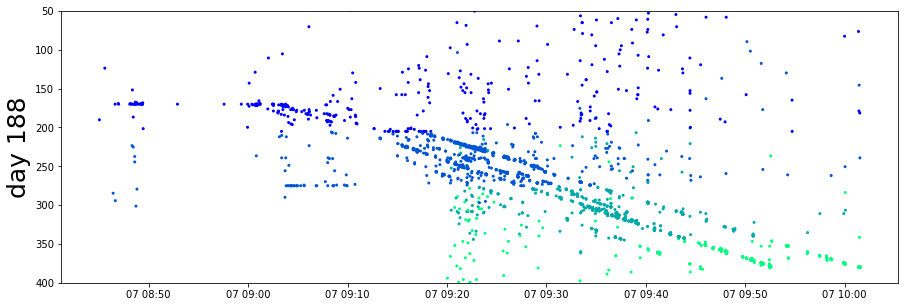

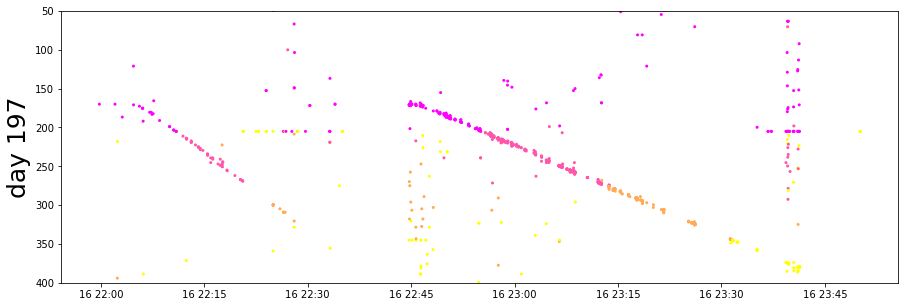

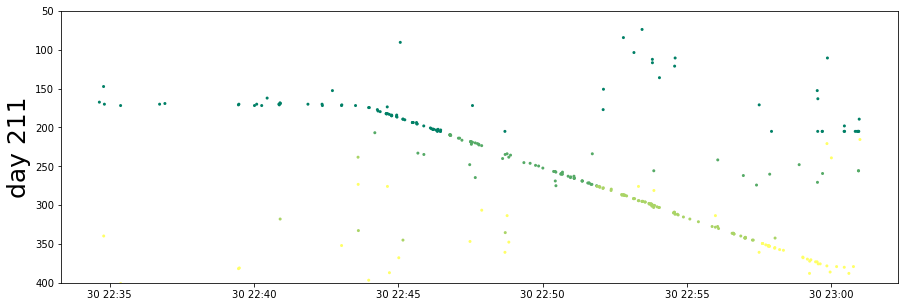

In [14]:
fig, ax = plot_depths(df=df141, cmap='cool', day=141)
fig.savefig('figures/day141_depths.pdf', bbox_inches='tight')

fig, ax = plot_depths(df=df188, cmap='winter', day=188)
fig.savefig('figures/day188_depths.pdf', bbox_inches='tight')

fig, ax = plot_depths(df=df197, cmap='spring', day=197)
fig.savefig('figures/day197_depths.pdf', bbox_inches='tight')

fig, ax = plot_depths(df=df211, cmap='summer', day=211)
fig.savefig('figures/day211_depths.pdf', bbox_inches='tight')


In [15]:
def remove_data_using_linear_model(X, y, removal_factor):
    
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    
    removal_index = np.hstack(
        (np.where(y > predictions + removal_factor*np.std(predictions))
        ,np.where(y < predictions - removal_factor*np.std(predictions)))
    )
    X_new = np.delete(X, removal_index)
    y_new = np.delete(y, removal_index)
    
    return X_new, y_new, model

def convert_matplotlib_numtimes_to_seconds_from_start(times):
    start = dates.num2date(times.min())
    end = dates.num2date(times.max())
    total_seconds = (end - start).total_seconds()

    seconds = np.array([(end - dates.num2date(t[0])).total_seconds() for t in times])
    return total_seconds - seconds

In [16]:
# y = df141.depth.values
# X = (df141.arrival_time).values.reshape(-1, 1)
# X = convert_matplotlib_numtimes_to_seconds_from_start(X)
# X = np.vstack(X)

# fig, ax = plt.subplots(figsize=(15, 5))
# ax.set_ylim(700, -300)

# ax.scatter(X, y, marker='.', color='black')

# xnew = X
# ynew = y
# iteration = 0
# removal_factor = 5
# while True:
#     xold = xnew.reshape(-1, 1)
#     yold = ynew
#     if 'r2' not in locals():
#         r2 = -9999
#         r2_old = r2
#     else:
#         r2_old = r2
#     xnew, ynew, mod = remove_data_using_linear_model(X=xold, y=yold, removal_factor=removal_factor)
#     pred = mod.predict(xold)
#     r2 = r2_score(yold, pred)
#     print('iteration:', iteration , '|'
#           , 'R2 score:', np.round(r2, 6), '+/-', removal_factor, '*', np.std(pred), '|'
#           , 'removed N=', yold.shape[0] - ynew.shape[0], '|'
#           , 'velocity (m/s):', mod.coef_, '|'
#           , 'starting depth(m):', mod.intercept_
#          )
#     ########
#     # plotting nonsense
#     color = plt.cm.jet(iteration/7.5)
#     ax.scatter(xnew, ynew, marker='.', color=color)
#     xline = np.linspace(X.min(), X.max(), 1000)
#     yline = mod.predict(xline.reshape(-1, 1))
#     ax.plot(xline, yline, color=color)
#     #
#     ########
    
#     iteration += 1
#     if r2 > 0.8:
#         break
#     # elif r2_old == r2:
#     elif np.isclose(r2_old, r2, rtol=1e-6):
#         removal_factor = removal_factor - 1.0
#     elif iteration == 1000:
#         break
#     else:
#         pass
    
# # ax.plot(xline, yline, color='red')
# ax.legend(np.arange(iteration), title='iteration')

In [17]:
# mod.intercept_

In [18]:
def do(df):

    y = df.depth.values
    X = (df.arrival_time).values.reshape(-1, 1)
    X = convert_matplotlib_numtimes_to_seconds_from_start(X)
    X = np.vstack(X)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_ylim(700, -300)

    ax.scatter(X, y, marker='.', color='black')

    xnew = X
    ynew = y
    iteration = 0
    removal_factor = 5
    while True:
        xold = xnew.reshape(-1, 1)
        yold = ynew
        if 'r2' not in locals():
            r2 = -9999
            r2_old = r2
        else:
            r2_old = r2
        xnew, ynew, mod = remove_data_using_linear_model(X=xold, y=yold, removal_factor=removal_factor)
        pred = mod.predict(xold)
        r2 = r2_score(yold, pred)
        print('iteration:', iteration , '|'
              , 'R2 score:', np.round(r2, 6), '+/-', removal_factor, '*', np.std(pred), '|'
              , 'removed N=', yold.shape[0] - ynew.shape[0], '|'
              , 'velocity (m/s):', mod.coef_, '|'
              , 'starting depth:', mod.intercept_
             )
        ########
        # plotting nonsense
        color = plt.cm.jet(iteration/7.5)
        ax.scatter(xnew, ynew, marker='.', color=color)
        xline = np.linspace(X.min(), X.max(), 1000)
        yline = mod.predict(xline.reshape(-1, 1))
        ax.plot(xline, yline, color=color)
        #
        ########

        iteration += 1
        if r2 > 0.8:
            break
        # elif r2_old == r2:
        elif np.isclose(r2_old, r2, rtol=1e-6):
            removal_factor = removal_factor - 1.0
        elif iteration == 1000:
            break
        else:
            pass

    # ax.plot(xline, yline, color='red')
    ax.legend(np.arange(iteration), title='iteration')

iteration: 0 | R2 score: 0.094327 +/- 5 * 31.076143350693656 | removed N= 163 | velocity (m/s): [0.02765019] | starting depth: 216.76006551472696
iteration: 1 | R2 score: 0.70317 +/- 5 * 55.66865348580648 | removed N= 0 | velocity (m/s): [0.04999229] | starting depth: 184.24096113716718
iteration: 2 | R2 score: 0.70317 +/- 5 * 55.66865348580648 | removed N= 0 | velocity (m/s): [0.04999229] | starting depth: 184.24096113716718
iteration: 3 | R2 score: 0.70317 +/- 4.0 * 55.66865348580648 | removed N= 0 | velocity (m/s): [0.04999229] | starting depth: 184.24096113716718
iteration: 4 | R2 score: 0.70317 +/- 3.0 * 55.66865348580648 | removed N= 11 | velocity (m/s): [0.04999229] | starting depth: 184.24096113716718
iteration: 5 | R2 score: 0.737009 +/- 2.0 * 56.70987494446255 | removed N= 71 | velocity (m/s): [0.0510321] | starting depth: 182.27601646284393
iteration: 6 | R2 score: 0.909694 +/- 2.0 * 62.40671432471288 | removed N= 0 | velocity (m/s): [0.05707571] | starting depth: 169.174964

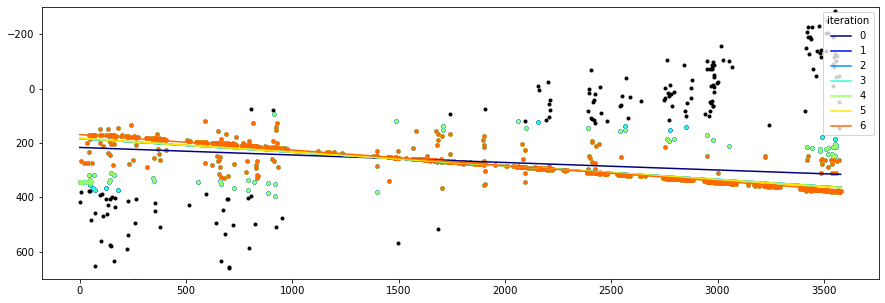

In [19]:
do(df=df141)

iteration: 0 | R2 score: 0.270046 +/- 5 * 38.47959043734055 | removed N= 66 | velocity (m/s): [0.04533875] | starting depth: 138.9882434659579
iteration: 1 | R2 score: 0.477398 +/- 5 * 44.374055102725634 | removed N= 0 | velocity (m/s): [0.05213977] | starting depth: 128.71003606300192
iteration: 2 | R2 score: 0.477398 +/- 5 * 44.374055102725634 | removed N= 0 | velocity (m/s): [0.05213977] | starting depth: 128.71003606300192
iteration: 3 | R2 score: 0.477398 +/- 4.0 * 44.374055102725634 | removed N= 20 | velocity (m/s): [0.05213977] | starting depth: 128.71003606300192
iteration: 4 | R2 score: 0.536466 +/- 3.0 * 45.848086529901444 | removed N= 43 | velocity (m/s): [0.05393373] | starting depth: 125.8382258090287
iteration: 5 | R2 score: 0.633849 +/- 3.0 * 47.86952152932426 | removed N= 0 | velocity (m/s): [0.05652482] | starting depth: 120.82356927421404
iteration: 6 | R2 score: 0.633849 +/- 3.0 * 47.86952152932426 | removed N= 0 | velocity (m/s): [0.05652482] | starting depth: 120.8

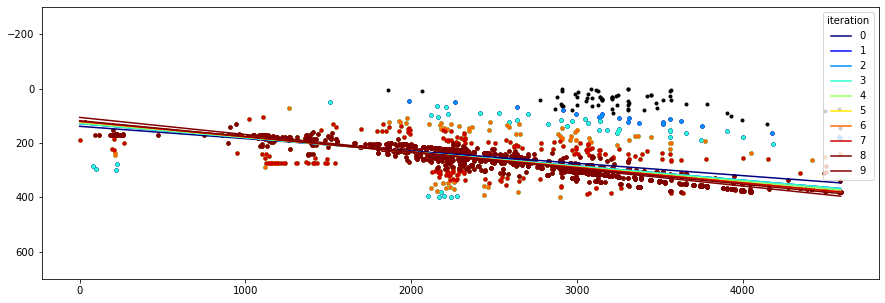

In [20]:
do(df=df188[df188.depth.between(0, 400)])


iteration: 0 | R2 score: 0.132151 +/- 5 * 23.395451504280427 | removed N= 43 | velocity (m/s): [0.02254481] | starting depth: 197.0712705125484
iteration: 1 | R2 score: 0.420505 +/- 5 * 36.14494096692799 | removed N= 0 | velocity (m/s): [0.03581487] | starting depth: 174.1714871039482
iteration: 2 | R2 score: 0.420505 +/- 5 * 36.14494096692799 | removed N= 0 | velocity (m/s): [0.03581487] | starting depth: 174.1714871039482
iteration: 3 | R2 score: 0.420505 +/- 4.0 * 36.14494096692799 | removed N= 1 | velocity (m/s): [0.03581487] | starting depth: 174.1714871039482
iteration: 4 | R2 score: 0.427909 +/- 3.0 * 36.44442457955488 | removed N= 32 | velocity (m/s): [0.03617945] | starting depth: 173.63936813815315
iteration: 5 | R2 score: 0.631254 +/- 3.0 * 44.00460461433327 | removed N= 0 | velocity (m/s): [0.04605404] | starting depth: 157.55121089931112
iteration: 6 | R2 score: 0.631254 +/- 3.0 * 44.00460461433327 | removed N= 0 | velocity (m/s): [0.04605404] | starting depth: 157.5512108

0.05833333333333333

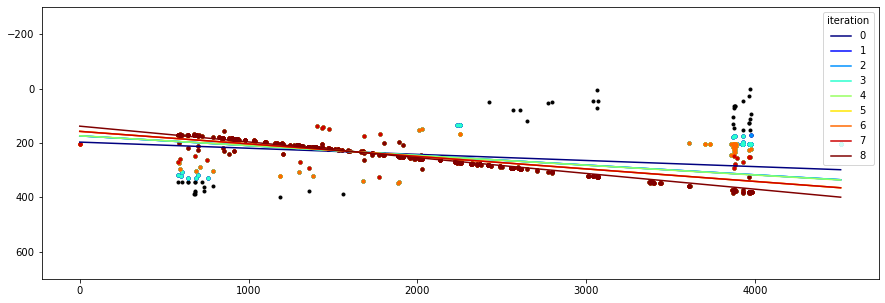

In [21]:
# remove the first event which is small
df = df197[155:]
do(df=df[df.depth.between(0, 400)])
(0.057+0.061+0.057)/3

iteration: 0 | R2 score: 0.161908 +/- 5 * 28.766727903013873 | removed N= 14 | velocity (m/s): [0.09440124] | starting depth: 212.14567610196104
iteration: 1 | R2 score: 0.357809 +/- 5 * 36.875277346768286 | removed N= 0 | velocity (m/s): [0.1206991] | starting depth: 206.98841646268858
iteration: 2 | R2 score: 0.357809 +/- 5 * 36.875277346768286 | removed N= 0 | velocity (m/s): [0.1206991] | starting depth: 206.98841646268858
iteration: 3 | R2 score: 0.357809 +/- 4.0 * 36.875277346768286 | removed N= 1 | velocity (m/s): [0.1206991] | starting depth: 206.98841646268858
iteration: 4 | R2 score: 0.376758 +/- 3.0 * 37.69918635328954 | removed N= 20 | velocity (m/s): [0.12364848] | starting depth: 206.18217467116762
iteration: 5 | R2 score: 0.736896 +/- 3.0 * 50.40586389583022 | removed N= 0 | velocity (m/s): [0.17405459] | starting depth: 190.56671855456017
iteration: 6 | R2 score: 0.736896 +/- 3.0 * 50.40586389583022 | removed N= 0 | velocity (m/s): [0.17405459] | starting depth: 190.566

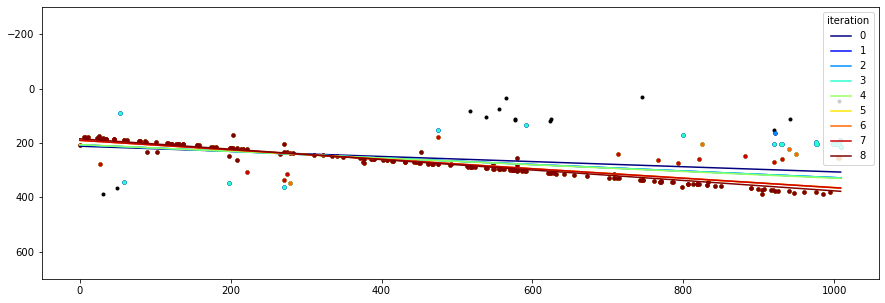

In [22]:
# remove first few events which make fitline nonlinear
df = df211[40:]
do(df=df[df.depth.between(0, 400)])

In [23]:
df141.columns

Index(['Unnamed: 0', 'id', 'depth', 'relative_depth', 'radius', 'aic_t',
       'aics', 'aic_maxes', 'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt', 'parrival',
       'arrival_datetime'],
      dtype='object')

In [24]:
df141['better_radius'] = np.sqrt(4500**2 * df141.dt.values**2 - df141.relative_depth.values**2)


/tmp/ipykernel_14305/2760798133.py:1: RuntimeWarning: invalid value encountered in sqrt
  df141['better_radius'] = np.sqrt(4500**2 * df141.dt.values**2 - df141.relative_depth.values**2)


<AxesSubplot:>

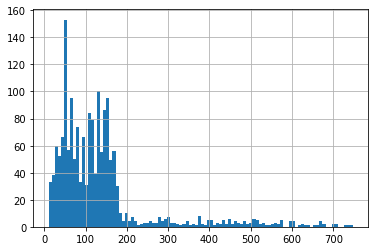

In [25]:
df141.better_radius.hist(bins=100)

(<Figure size 1080x360 with 2 Axes>,
 <AxesSubplot:xlabel='time ---->', ylabel='radius (m)'>)

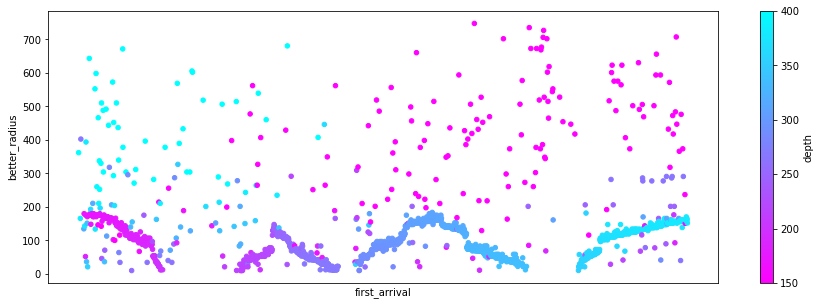

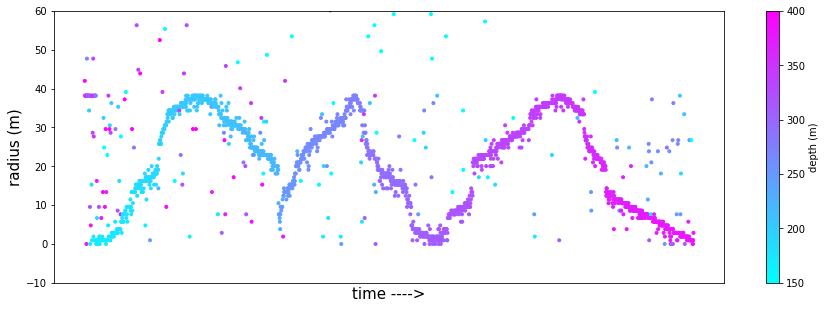

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
cbar = df141.plot.scatter(x='first_arrival', y='better_radius', ax=ax, c='depth', cmap='cool_r', vmin=150, vmax=400)
ax.set_xticks([])
plot_radius(df=df141, cmap='cool', day=141)


(<Figure size 1080x360 with 2 Axes>,
 <AxesSubplot:xlabel='time ---->', ylabel='radius (m)'>)

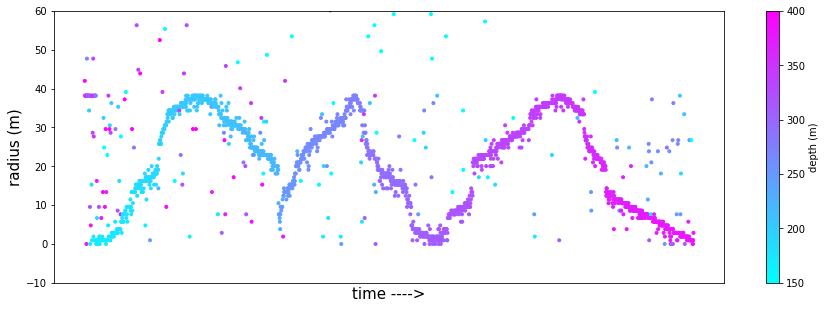

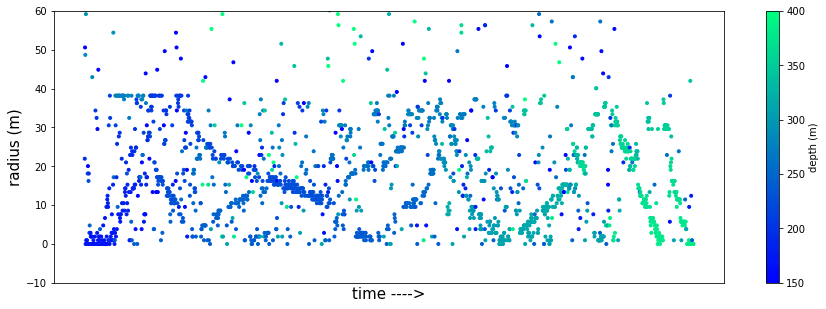

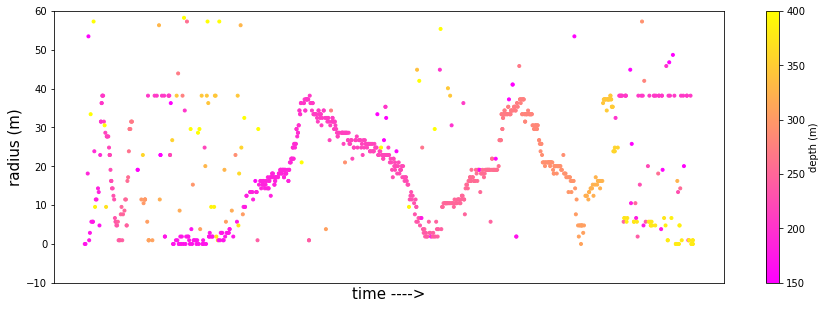

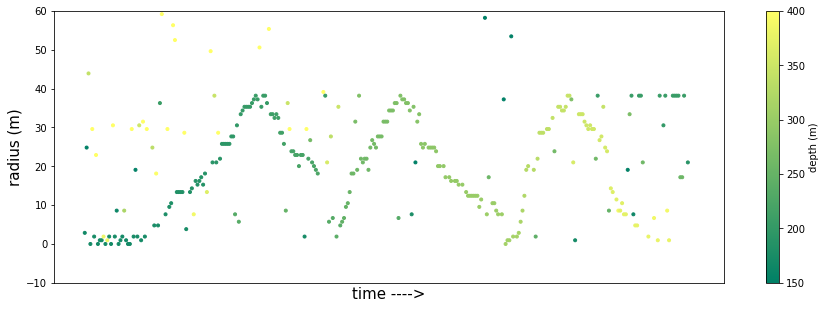

In [27]:
plot_radius(df=df141, cmap='cool', day=141)
plot_radius(df=df188, cmap='winter', day=188)
plot_radius(df=df197, cmap='spring', day=197)
plot_radius(df=df211, cmap='summer', day=211)

<AxesSubplot:xlabel='depth', ylabel='radius'>

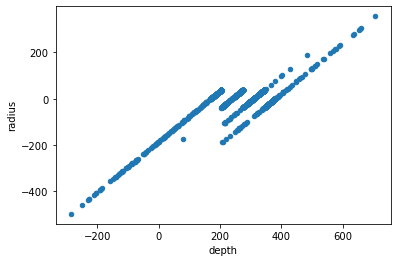

In [28]:
df141.plot.scatter(x='depth', y='radius')

<AxesSubplot:>

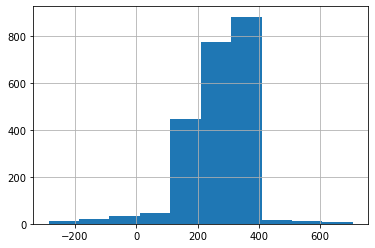

In [29]:
df141.depth.hist()

In [30]:
df141.columns

Index(['Unnamed: 0', 'id', 'depth', 'relative_depth', 'radius', 'aic_t',
       'aics', 'aic_maxes', 'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt', 'parrival',
       'arrival_datetime', 'better_radius'],
      dtype='object')

In [31]:
df141[['depth', 'radius', 'first_hydrophone', 'second_hydrophone']].corr()

,depth,radius,first_hydrophone,second_hydrophone
depth,1.000000,0.691810,0.822284,0.191265
radius,0.691810,1.000000,0.157944,0.002187
first_hydrophone,0.822284,0.157944,1.000000,0.259832
second_hydrophone,0.191265,0.002187,0.259832,1.000000


<AxesSubplot:>

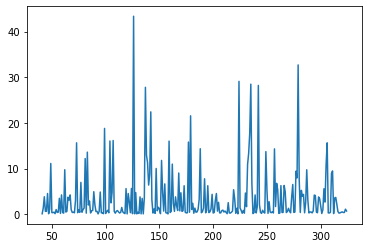

In [32]:
df141['first_arrival'] = df.first_arrival.apply(pd.to_datetime)
df141['diff'] = df141.first_arrival.diff().apply(lambda t: t.total_seconds())

df141['diff'].plot()

<AxesSubplot:>

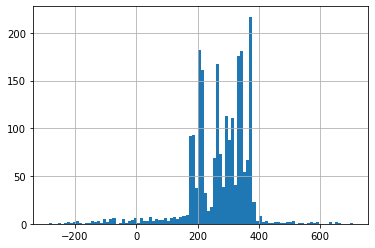

In [33]:
df141.depth.hist(bins=100)

In [34]:
(310 - df141.iloc[1500].depth)/1750

-0.0125

In [35]:
def make_time_interval_plots(df):
    df = df.copy().sort_values(by='first_arrival')
    
    df['first_arrival'] = df.first_arrival.apply(pd.to_datetime)
    df['diff'] = df.first_arrival.diff().apply(lambda t: t.total_seconds())
    df.set_index('first_arrival', inplace=True)
    
    fig, ax = plt.subplots()
    df['diff'].plot(ax=ax)
    
    fig, ax = plt.subplots()
    df['diff'].hist(bins=np.linspace(0, 20, 100), log=True, ax=ax)

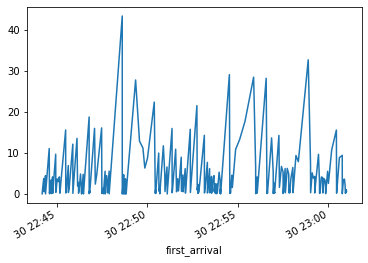

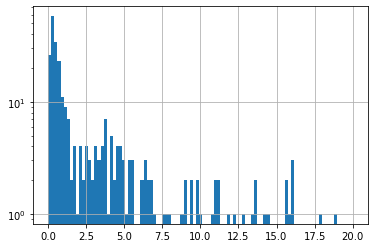

In [36]:
make_time_interval_plots(df=df141)

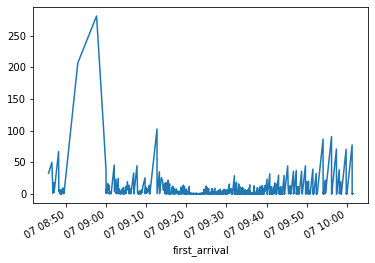

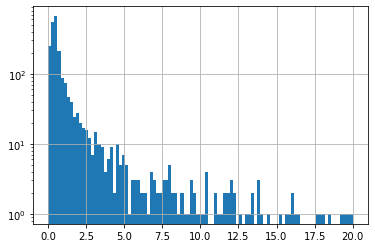

In [37]:
make_time_interval_plots(df=df188)

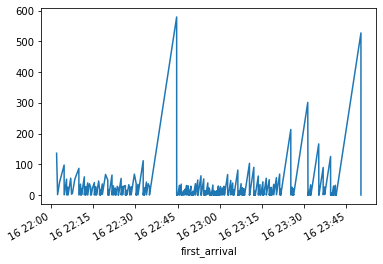

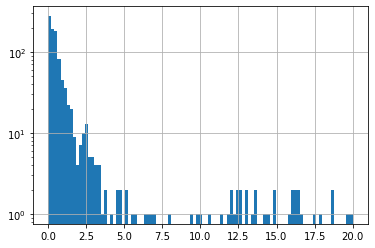

In [38]:
make_time_interval_plots(df=df197)

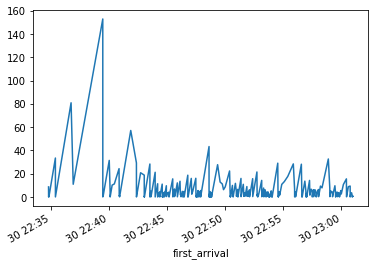

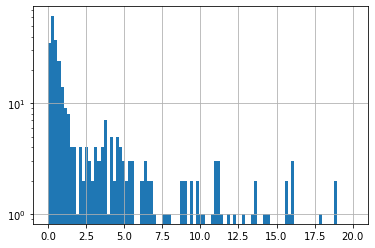

In [39]:
make_time_interval_plots(df=df211)

In [40]:
# what if its at the borehole wall?
import config
config.hydrophone_metadata_141['h3']

{'start': 2019-05-21T07:35:00.000000Z,
 'end': 2019-05-21T07:48:00.000000Z,
 'depth': 170,
 'velocity_model': 1750}

In [41]:
df141.first_hydrophone.unique()

array([5, 4, 3, 2])

In [42]:
phone_depths = []
for first_phone in df141.first_hydrophone.values:
    phone_id = 'h'+str(first_phone+1)
    dh = config.hydrophone_metadata_141[phone_id]['depth']
    phone_depths.append(dh)
    
df141['first_phone_depth'] = phone_depths

In [43]:
wall_velocities = (df141.first_phone_depth - df141.depth)/(pd.to_datetime(df141.first_arrival) - pd.to_datetime(df141.parrival)).apply(lambda t: t.total_seconds())

In [44]:
wall_velocities.replace([np.inf, -np.inf], np.nan, inplace=True)


<AxesSubplot:>

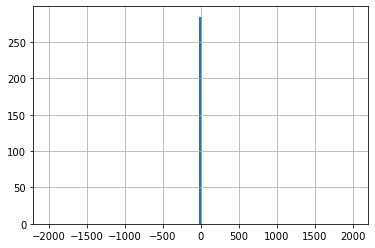

In [45]:
wall_velocities.abs().hist(bins=np.linspace(-2000, 2000, 100))

<AxesSubplot:>

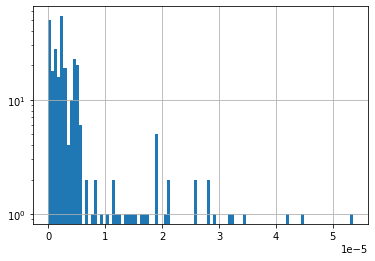

In [46]:
wall_velocities.abs().hist(bins=100, log=True)

In [47]:
wall_velocities.abs().mean()

4.626484164477326e-06

In [48]:
wall_velocities.abs().std()

7.372749246362916e-06

<AxesSubplot:>

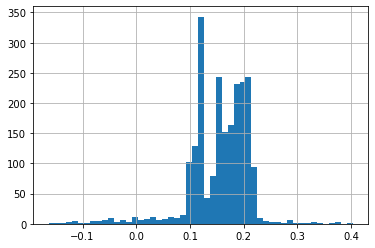

In [49]:
(df141.depth/1750
).hist(bins=51)

In [50]:
(df141.depth/6800).mean()

0.03991906350893771

<AxesSubplot:>

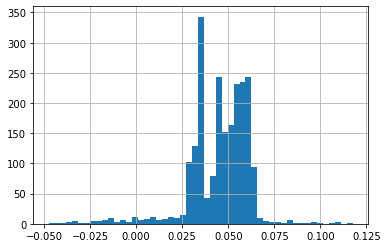

In [51]:
(df141.depth/6000).hist(bins=51)

In [52]:
df141.iloc[750]

velocity = 
# [rows, cols]
dist_from_borehole = np.zeros([240-170, 51])
# for i in np.arange(dist_from_borehole.shape[0]):
for row in np.arange(dist_from_borehole.shape[0]):
    for col in np.arange(dist_from_borehole.shape[1]):
        

SyntaxError: invalid syntax (3575041646.py, line 3)

In [ ]:
dist_from_borehole.shape

In [ ]:
config.hydrophone_metadata_141['h3']

In [ ]:
config.hydrophone_metadata_141['h4']